<a href="https://colab.research.google.com/github/yuezhonggg/Balance-Pole-on-a-Cart-Reinforcement-Learning/blob/master/Assignment_1_(DQN)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [42]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install tensorflow 


The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.


## Importing dependencies and define helper functions

In [43]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [44]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [45]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [46]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [47]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([ 0.02525905,  0.01815824,  0.01911109, -0.02030161], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [48]:
observation, reward, done, info , _= env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02562222 -0.17723249  0.01870506  0.2783493 ]
Reward for this step: 1.0
Is this round done? False


c:\Users\Yue Zhong\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [49]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info , _ = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent


***Selection of GPU system to use***

In [50]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

***Importing Dependecies***

In [51]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

***Setting Parameters***

In [52]:
env = gym.make("CartPole-v1")

In [53]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 32
n_episodes = 301
output_dir = 'model_output/cartpole'


In [54]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

***DQN Agent***

In [55]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=2000)

        self.gamma = 0.95  # discount rate -> for future reward

        self.epsilon = 1.0  # exploration rate -> to explore randomly so can get more data
        self.epsilon_min = 0.01 # the lowest it will go
        self.epsilon_decay = 0.995 # change exploration rate then will slowly stop doing randomly to get more data

        self.learning_rate = 0.001

        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load (self, name):
      self.model.load_weights(name)

    def save (self, name):
      self.model.save_weights(name)


***Training of DQN Agent*** Took 52 mins for 300 episodes

In [56]:
agent = DQNAgent(state_size, action_size)
done = False
for e in range(n_episodes):
    state = env.reset()
    state = state[0]
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ , _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, epilson: {:.2}"
                  .format(e, n_episodes, time, agent.epsilon))
            break
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    if e % 50 == 0:
        agent.save(output_dir + "weights" + '{:04d}'.format(e) + ".hdf5")


episode: 0/301, score: 41, epilson: 1.0
1/1 [==============================] - 0s 12ms/step


c:\Users\Yue Zhong\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 12ms/step
episode: 1/301, score: 13, epilson: 0.99
1/1 [==============================] - 0s 12ms/step
episode: 2/301, score: 24, epilson: 0.99
1/1 [==============================] - 0s 16ms/step


KeyboardInterrupt: 

In [ ]:
model = agent.load('model_output/cartpole')
model.summary()

PermissionError: [Errno 13] Unable to open file (unable to open file: name = 'model_output/cartpole', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

For Task 1, we can show the observation and chosen action below:

In [32]:
observation = env.reset()
observation = observation[0]
observation = np.reshape(observation, [1, state_size])
action = agent.act(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [[-0.01589327 -0.03433499  0.03961333 -0.04752574]]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

1/1 [==============================] - 0s 12ms/step


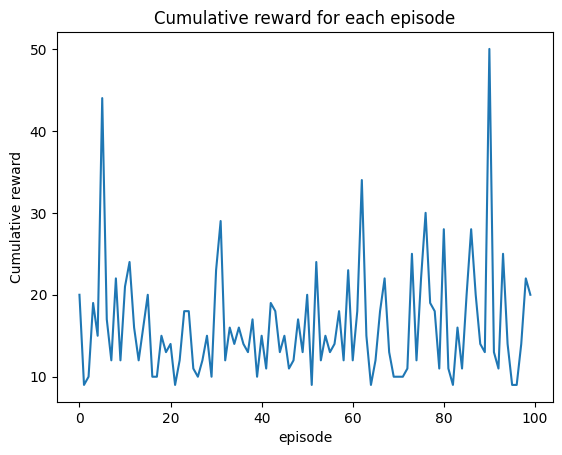

In [39]:
t2 = 100
episode_results = []
for episode in range(t2):
  done = False
  total = 0
  observation = env.reset()
  observation = observation[0]
  observation = np.reshape(observation, [1, state_size])

  while not done:
    action = agent.act(observation)
    next_state, reward, done, info , _ = env.step(action)
    total += reward
    if done:
      break
    
  episode_results.append(total)

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [38]:
print("Average cumulative reward:", sum(episode_results)/len(episode_results))
print("Is my agent good enough?", sum(episode_results)/len(episode_results) > 195)

Average cumulative reward: 17.35
Is my agent good enough? False


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
state = discretize_state(observation)
print(observation)
print(state)
while True:
    env.render()
    #agent goes here
    action = np.argmax(q_table[state])
    print(action)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()